# Sensitivity Analysis: How Input Changes Affect Recommendations

This notebook demonstrates **sensitivity analysis** - a critical validation technique that tests how model recommendations change when inputs change.

Understanding sensitivity analysis is essential because:
- **Model inputs are estimates, not exact values** - they contain uncertainty
- **Sensitive recommendations are risky** - small input errors can lead to bad decisions
- **Sensitivity analysis reveals which inputs matter most** - helps you prioritize where to invest effort
- **Robust recommendations are safer** - they work well even when inputs vary


## Key Concepts

**Sensitivity Analysis** tests how model outputs change when inputs change:
- You vary one input at a time and observe how the recommendation changes
- If the recommendation changes a lot, the model is **sensitive** to that input
- If the recommendation changes little, the model is **not sensitive** to that input

**Why It Matters**:
- **Sensitive inputs are critical** - you need accurate estimates for these
- **Less sensitive inputs are less critical** - rough estimates may be sufficient
- **Sensitive recommendations are fragile** - they depend on precise assumptions
- **Robust recommendations are safer** - they work well even when inputs vary

**Critical insight**: Sensitivity analysis helps you understand which assumptions matter most and which recommendations are risky.


## Scenario: Production Planning with Uncertain Demand

You manage a factory that produces two products: Widget A and Widget B. You need to decide how many units of each to produce next month.

**The Challenge**: Your demand forecasts are uncertain. You estimate:
- Demand for Widget A: 1,000 units (but could be 900-1,100)
- Demand for Widget B: 800 units (but could be 700-900)

**The Question**: How sensitive is your production recommendation to these demand forecasts? If demand is slightly different than expected, does your recommendation change dramatically?

**Decision variables**: How many units of each product to produce

**Inputs to test**: Demand forecasts, profit margins, capacity limits


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value, PULP_CBC_CMD


## Step 3: Set Up Base Model

First, let's create a base production planning model with our initial estimates:


In [3]:
# Base inputs (our best estimates)
demand_A_base = 1000  # Estimated demand for Widget A
demand_B_base = 800   # Estimated demand for Widget B

profit_A = 50    # Profit per unit of Widget A ($)
profit_B = 40    # Profit per unit of Widget B ($)

capacity = 2000   # Total production capacity (units)
labor_hours = 1500  # Available labor hours

labor_per_A = 0.5  # Labor hours per Widget A
labor_per_B = 0.8  # Labor hours per Widget B

print("BASE MODEL INPUTS:")
print(f"  Demand A: {demand_A_base} units")
print(f"  Demand B: {demand_B_base} units")
print(f"  Profit per A: ${profit_A}")
print(f"  Profit per B: ${profit_B}")
print(f"  Capacity: {capacity} units")
print(f"  Labor hours: {labor_hours} hours")


BASE MODEL INPUTS:
  Demand A: 1000 units
  Demand B: 800 units
  Profit per A: $50
  Profit per B: $40
  Capacity: 2000 units
  Labor hours: 1500 hours


## Step 4: Create a Function to Solve the Model

We'll create a function that takes inputs and returns the optimal production recommendation:


In [4]:
def solve_production_model(demand_A, demand_B, profit_A, profit_B, capacity, labor_hours, labor_per_A, labor_per_B):
    """
    Solve production planning model with given inputs.
    Returns: (produce_A, produce_B, total_profit)
    """
    # Create model
    model = LpProblem("Production_Planning", LpMaximize)
    
    # Decision variables
    produce_A = LpVariable("produce_A", lowBound=0, cat='Integer')
    produce_B = LpVariable("produce_B", lowBound=0, cat='Integer')
    
    # Objective: Maximize profit
    model += profit_A * produce_A + profit_B * produce_B, "Total_Profit"
    
    # Constraints
    model += produce_A + produce_B <= capacity, "Capacity_Limit"
    model += labor_per_A * produce_A + labor_per_B * produce_B <= labor_hours, "Labor_Limit"
    model += produce_A <= demand_A, "Demand_A_Limit"
    model += produce_B <= demand_B, "Demand_B_Limit"
    
    # Solve (PULP_CBC_CMD(msg=0) suppresses solver output)
    model.solve(PULP_CBC_CMD(msg=0))
    
    # Return solution
    return (value(produce_A), value(produce_B), value(model.objective))

# Solve base model
base_A, base_B, base_profit = solve_production_model(
    demand_A_base, demand_B_base, profit_A, profit_B, 
    capacity, labor_hours, labor_per_A, labor_per_B
)

print("BASE MODEL RECOMMENDATION:")
print(f"  Produce {base_A:.0f} units of Widget A")
print(f"  Produce {base_B:.0f} units of Widget B")
print(f"  Total Profit: ${base_profit:,.0f}")


BASE MODEL RECOMMENDATION:
  Produce 1000 units of Widget A
  Produce 800 units of Widget B
  Total Profit: $82,000


In [5]:
# Test sensitivity to Demand A
demand_A_values = np.arange(900, 1101, 20)  # From 900 to 1100 in steps of 20
results_A = []

for d_A in demand_A_values:
    prod_A, prod_B, profit = solve_production_model(
        d_A, demand_B_base, profit_A, profit_B,
        capacity, labor_hours, labor_per_A, labor_per_B
    )
    results_A.append({
        'Demand_A': d_A,
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Total_Profit': profit,
        'Change_A': prod_A - base_A,
        'Change_B': prod_B - base_B,
        'Change_Profit': profit - base_profit
    })

sensitivity_A_df = pd.DataFrame(results_A)

print("SENSITIVITY ANALYSIS: Varying Demand A")
print("=" * 80)
display(sensitivity_A_df[['Demand_A', 'Produce_A', 'Produce_B', 'Total_Profit', 'Change_A', 'Change_B']].round(0))


SENSITIVITY ANALYSIS: Varying Demand A


,Demand_A,Produce_A,Produce_B,Total_Profit,Change_A,Change_B
0,900,900.0,800.0,77000.0,-100.0,0.0
1,920,920.0,800.0,78000.0,-80.0,0.0
2,940,940.0,800.0,79000.0,-60.0,0.0
3,960,960.0,800.0,80000.0,-40.0,0.0
4,980,980.0,800.0,81000.0,-20.0,0.0
5,1000,1000.0,800.0,82000.0,0.0,0.0
6,1020,1020.0,800.0,83000.0,20.0,0.0
7,1040,1040.0,800.0,84000.0,40.0,0.0
8,1060,1060.0,800.0,85000.0,60.0,0.0
9,1080,1080.0,800.0,86000.0,80.0,0.0


## Step 6: Visualize Sensitivity to Demand A

Let's create visualizations to see how sensitive the recommendation is:


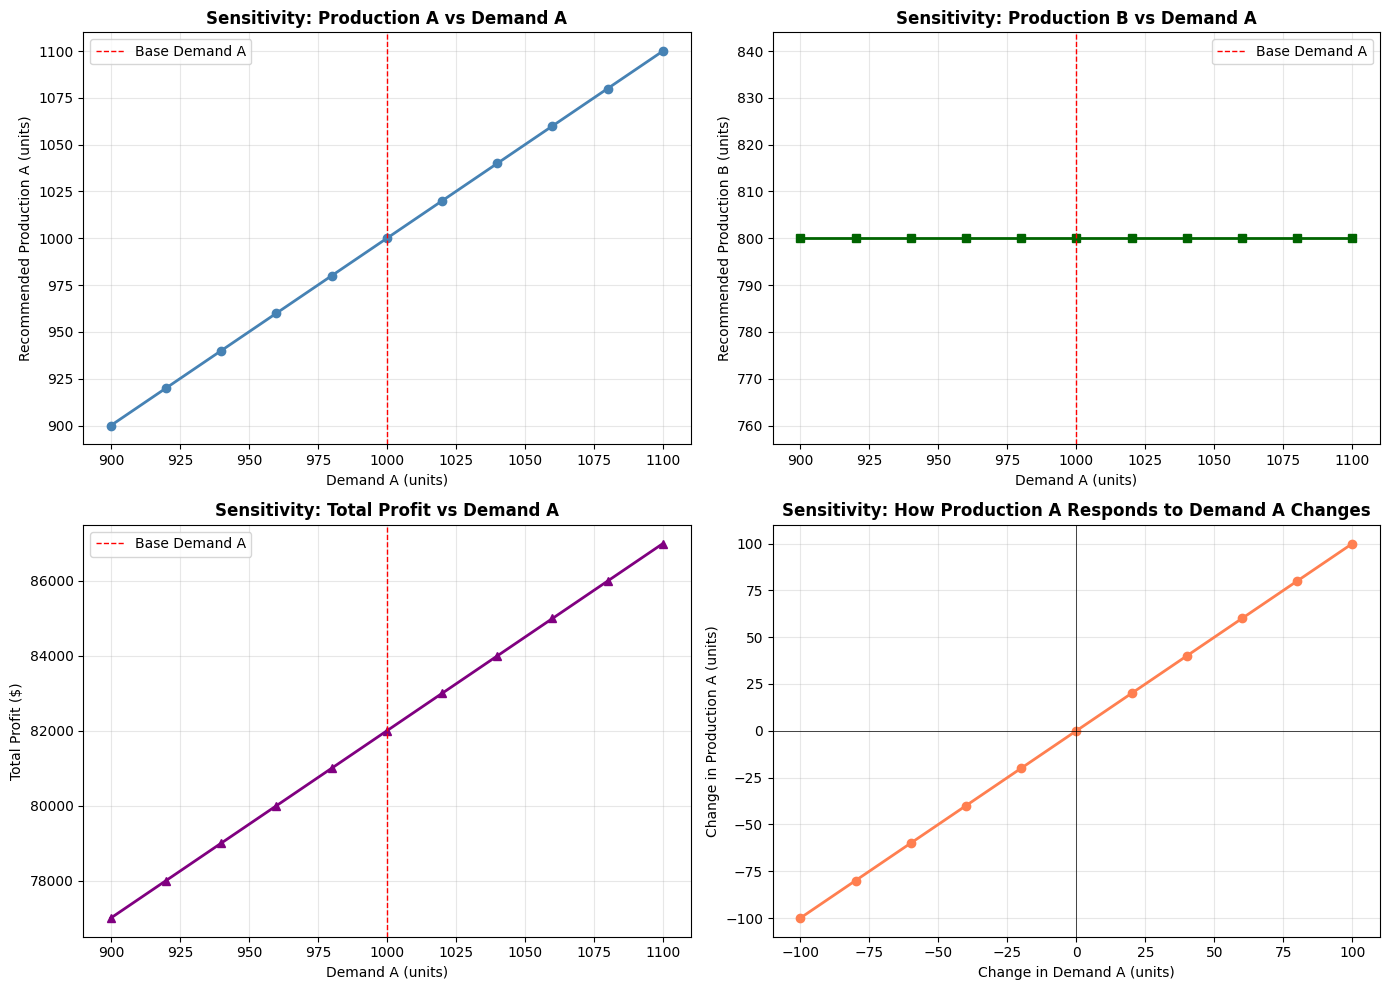


SENSITIVITY METRICS:
  When Demand A increases by 100 units (10.0%):
    Production A changes by 100 units
    Sensitivity ratio: 1.00 (production change per demand change)
    ⚠️  HIGHLY SENSITIVE - Recommendation changes significantly with demand changes


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Production A vs Demand A
ax1 = axes[0, 0]
ax1.plot(sensitivity_A_df['Demand_A'], sensitivity_A_df['Produce_A'], 
         marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=demand_A_base, color='red', linestyle='--', linewidth=1, label='Base Demand A')
ax1.set_xlabel('Demand A (units)')
ax1.set_ylabel('Recommended Production A (units)')
ax1.set_title('Sensitivity: Production A vs Demand A', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Production B vs Demand A
ax2 = axes[0, 1]
ax2.plot(sensitivity_A_df['Demand_A'], sensitivity_A_df['Produce_B'], 
         marker='s', linewidth=2, markersize=6, color='darkgreen')
ax2.axvline(x=demand_A_base, color='red', linestyle='--', linewidth=1, label='Base Demand A')
ax2.set_xlabel('Demand A (units)')
ax2.set_ylabel('Recommended Production B (units)')
ax2.set_title('Sensitivity: Production B vs Demand A', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Total Profit vs Demand A
ax3 = axes[1, 0]
ax3.plot(sensitivity_A_df['Demand_A'], sensitivity_A_df['Total_Profit'], 
         marker='^', linewidth=2, markersize=6, color='purple')
ax3.axvline(x=demand_A_base, color='red', linestyle='--', linewidth=1, label='Base Demand A')
ax3.set_xlabel('Demand A (units)')
ax3.set_ylabel('Total Profit ($)')
ax3.set_title('Sensitivity: Total Profit vs Demand A', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Change in Production A vs Change in Demand A
ax4 = axes[1, 1]
ax4.plot(sensitivity_A_df['Demand_A'] - demand_A_base, sensitivity_A_df['Change_A'], 
         marker='o', linewidth=2, markersize=6, color='coral')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Change in Demand A (units)')
ax4.set_ylabel('Change in Production A (units)')
ax4.set_title('Sensitivity: How Production A Responds to Demand A Changes', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate sensitivity metrics
change_demand_A = 100  # 10% change
change_prod_A = sensitivity_A_df[sensitivity_A_df['Demand_A'] == demand_A_base + change_demand_A]['Change_A'].values[0]
sensitivity_ratio_A = abs(change_prod_A / change_demand_A) if change_demand_A != 0 else 0

print(f"\nSENSITIVITY METRICS:")
print(f"  When Demand A increases by {change_demand_A} units ({change_demand_A/demand_A_base*100:.1f}%):")
print(f"    Production A changes by {change_prod_A:.0f} units")
print(f"    Sensitivity ratio: {sensitivity_ratio_A:.2f} (production change per demand change)")
if sensitivity_ratio_A > 0.8:
    print(f"    ⚠️  HIGHLY SENSITIVE - Recommendation changes significantly with demand changes")
elif sensitivity_ratio_A > 0.3:
    print(f"    ⚠️  MODERATELY SENSITIVE - Recommendation changes moderately with demand changes")
else:
    print(f"    ✓  LOW SENSITIVITY - Recommendation is relatively stable")


## Step 7: Test Sensitivity to Demand B

Now let's test sensitivity to Demand B:


In [7]:
# Test sensitivity to Demand B
demand_B_values = np.arange(700, 901, 20)  # From 700 to 900 in steps of 20
results_B = []

for d_B in demand_B_values:
    prod_A, prod_B, profit = solve_production_model(
        demand_A_base, d_B, profit_A, profit_B,
        capacity, labor_hours, labor_per_A, labor_per_B
    )
    results_B.append({
        'Demand_B': d_B,
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Total_Profit': profit,
        'Change_A': prod_A - base_A,
        'Change_B': prod_B - base_B,
        'Change_Profit': profit - base_profit
    })

sensitivity_B_df = pd.DataFrame(results_B)

print("SENSITIVITY ANALYSIS: Varying Demand B")
print("=" * 80)
display(sensitivity_B_df[['Demand_B', 'Produce_A', 'Produce_B', 'Total_Profit', 'Change_A', 'Change_B']].round(0))


SENSITIVITY ANALYSIS: Varying Demand B


,Demand_B,Produce_A,Produce_B,Total_Profit,Change_A,Change_B
0,700,1000.0,700.0,78000.0,0.0,-100.0
1,720,1000.0,720.0,78800.0,0.0,-80.0
2,740,1000.0,740.0,79600.0,0.0,-60.0
3,760,1000.0,760.0,80400.0,0.0,-40.0
4,780,1000.0,780.0,81200.0,0.0,-20.0
5,800,1000.0,800.0,82000.0,0.0,0.0
6,820,1000.0,820.0,82800.0,0.0,20.0
7,840,1000.0,840.0,83600.0,0.0,40.0
8,860,1000.0,860.0,84400.0,0.0,60.0
9,880,1000.0,880.0,85200.0,0.0,80.0


## Step 8: Compare Sensitivity Across All Inputs

Let's compare which inputs the model is most sensitive to:


SENSITIVITY COMPARISON: Which Input Matters Most?


,Input,Base Value,Test Change,Change %,Production Change,Sensitivity Ratio
0,Demand A,1000,100,10.0,100.0,1.0
1,Demand B,800,100,12.5,100.0,1.0
2,Profit A,50,10,20.0,0.0,0.0


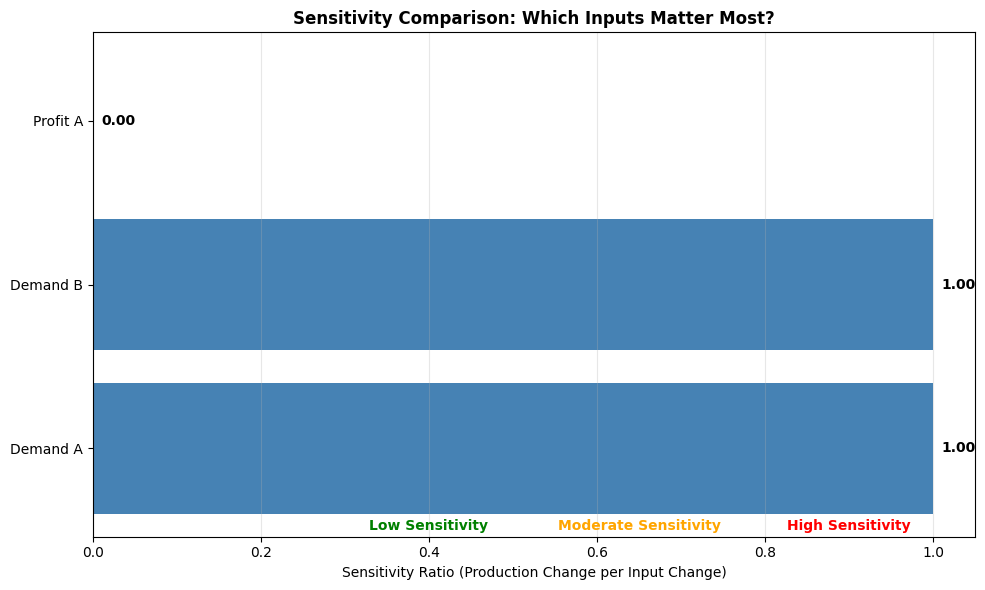


KEY INSIGHTS:
  • Most sensitive input: Demand A
  • You should invest more effort in getting accurate estimates for Demand A
  • Less sensitive inputs can use rougher estimates


In [8]:
# Calculate sensitivity metrics for both inputs
change_demand_B = 100  # 12.5% change
change_prod_B = sensitivity_B_df[sensitivity_B_df['Demand_B'] == demand_B_base + change_demand_B]['Change_B'].values[0]
sensitivity_ratio_B = abs(change_prod_B / change_demand_B) if change_demand_B != 0 else 0

# Test sensitivity to profit margins
profit_A_values = np.arange(45, 61, 2)  # From $45 to $60 (extended to include base + change)
results_profit_A = []
for p_A in profit_A_values:
    prod_A, prod_B, profit = solve_production_model(
        demand_A_base, demand_B_base, p_A, profit_B,
        capacity, labor_hours, labor_per_A, labor_per_B
    )
    results_profit_A.append({
        'Profit_A': p_A,
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Change_A': prod_A - base_A
    })
profit_A_df = pd.DataFrame(results_profit_A)
change_profit_A = 10  # $10 change
target_profit = profit_A + change_profit_A
filtered = profit_A_df[profit_A_df['Profit_A'] == target_profit]
if len(filtered) > 0:
    change_prod_A_profit = filtered['Change_A'].values[0]
else:
    # If exact value not found, use closest value
    closest_idx = (profit_A_df['Profit_A'] - target_profit).abs().idxmin()
    change_prod_A_profit = profit_A_df.loc[closest_idx, 'Change_A']
sensitivity_ratio_profit_A = abs(change_prod_A_profit / change_profit_A) if change_profit_A != 0 else 0

# Create comparison
sensitivity_comparison = pd.DataFrame({
    'Input': ['Demand A', 'Demand B', 'Profit A'],
    'Base Value': [demand_A_base, demand_B_base, profit_A],
    'Test Change': [change_demand_A, change_demand_B, change_profit_A],
    'Change %': [change_demand_A/demand_A_base*100, change_demand_B/demand_B_base*100, change_profit_A/profit_A*100],
    'Production Change': [change_prod_A, change_prod_B, change_prod_A_profit],
    'Sensitivity Ratio': [sensitivity_ratio_A, sensitivity_ratio_B, sensitivity_ratio_profit_A]
})

print("SENSITIVITY COMPARISON: Which Input Matters Most?")
print("=" * 80)
display(sensitivity_comparison.round(2))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['steelblue' if r > 0.5 else 'coral' if r > 0.2 else 'lightgreen' 
          for r in sensitivity_comparison['Sensitivity Ratio']]
bars = ax.barh(sensitivity_comparison['Input'], sensitivity_comparison['Sensitivity Ratio'], color=colors)
ax.set_xlabel('Sensitivity Ratio (Production Change per Input Change)')
ax.set_title('Sensitivity Comparison: Which Inputs Matter Most?', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, ratio) in enumerate(zip(bars, sensitivity_comparison['Sensitivity Ratio'])):
    ax.text(ratio + 0.01, i, f'{ratio:.2f}', va='center', fontweight='bold')

# Add sensitivity level annotations
ax.text(0.4, -0.5, 'Low Sensitivity', ha='center', color='green', fontweight='bold')
ax.text(0.65, -0.5, 'Moderate Sensitivity', ha='center', color='orange', fontweight='bold')
ax.text(0.9, -0.5, 'High Sensitivity', ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKEY INSIGHTS:")
most_sensitive = sensitivity_comparison.loc[sensitivity_comparison['Sensitivity Ratio'].idxmax(), 'Input']
print(f"  • Most sensitive input: {most_sensitive}")
print(f"  • You should invest more effort in getting accurate estimates for {most_sensitive}")
print(f"  • Less sensitive inputs can use rougher estimates")


## Step 9: Interactive Exploration

Try modifying the inputs below to see how sensitive the recommendation is:


In [9]:
# Try different demand values and see how recommendations change
test_demand_A = 950  # Try values between 900-1100
test_demand_B = 750  # Try values between 700-900

test_A, test_B, test_profit = solve_production_model(
    test_demand_A, test_demand_B, profit_A, profit_B,
    capacity, labor_hours, labor_per_A, labor_per_B
)

comparison = pd.DataFrame({
    'Scenario': ['Base', 'Test'],
    'Demand A': [demand_A_base, test_demand_A],
    'Demand B': [demand_B_base, test_demand_B],
    'Produce A': [base_A, test_A],
    'Produce B': [base_B, test_B],
    'Total Profit': [base_profit, test_profit],
    'Change A': [0, test_A - base_A],
    'Change B': [0, test_B - base_B],
    'Change Profit': [0, test_profit - base_profit]
})

print("COMPARISON: Base vs Test Scenario")
print("=" * 80)
display(comparison.round(0))

print(f"\nWhen Demand A changes by {test_demand_A - demand_A_base} units ({((test_demand_A - demand_A_base)/demand_A_base*100):.1f}%):")
print(f"  Production A changes by {test_A - base_A:.0f} units ({((test_A - base_A)/base_A*100 if base_A > 0 else 0):.1f}%)")
print(f"  Production B changes by {test_B - base_B:.0f} units ({((test_B - base_B)/base_B*100 if base_B > 0 else 0):.1f}%)")
print(f"  Profit changes by ${test_profit - base_profit:,.0f} ({((test_profit - base_profit)/base_profit*100):.1f}%)")


COMPARISON: Base vs Test Scenario


,Scenario,Demand A,Demand B,Produce A,Produce B,Total Profit,Change A,Change B,Change Profit
0,Base,1000,800,1000.0,800.0,82000.0,0.0,0.0,0.0
1,Test,950,750,950.0,750.0,77500.0,-50.0,-50.0,-4500.0



When Demand A changes by -50 units (-5.0%):
  Production A changes by -50 units (-5.0%)
  Production B changes by -50 units (-6.2%)
  Profit changes by $-4,500 (-5.5%)


## Summary: Sensitivity Analysis

**What We Learned**:
- **Sensitivity analysis** tests how recommendations change when inputs change
- **Sensitive inputs** cause large changes in recommendations - these need accurate estimates
- **Less sensitive inputs** cause small changes - rough estimates may be sufficient
- **Sensitive recommendations are fragile** - they depend on precise assumptions
- **Robust recommendations are safer** - they work well even when inputs vary

**Key Insights**:
1. **Identify critical inputs**: Sensitivity analysis reveals which inputs matter most
2. **Prioritize data collection**: Invest effort in getting accurate estimates for sensitive inputs
3. **Understand risk**: Sensitive recommendations are risky when inputs are uncertain
4. **Choose robust solutions**: When possible, prefer recommendations that are less sensitive

**Practical Application**:
- Always perform sensitivity analysis before implementing model recommendations
- Focus your data collection efforts on inputs that matter most
- Be cautious about recommendations that are highly sensitive to uncertain inputs
- Consider choosing more robust alternatives when sensitivity is high
